In [1]:
# 1. Import packages
import amici
import matplotlib as mpl
import numpy as np
import petab
import logging

import pypesto.optimize as optimize
import pypesto.petab
import pypesto.profile as profile
import pypesto.sample as sample
import pypesto.store as store
import pypesto.visualize as visualize
import pypesto.visualize.model_fit as model_fit
import pypesto

# Set seed for reproducibility
np.random.seed(1912)

In [2]:
# 2. Import the model
model_name = "Boehm_JProteomeRes2014"
# change path if needed
petab_yaml = f"../../models/{model_name}/{model_name}.yaml"
petab_problem = petab.Problem.from_yaml(petab_yaml)
importer = pypesto.petab.PetabImporter(petab_problem)
problem = importer.create_problem(verbose=False)

In [ ]:
.amici_solver.getAproblem.objectivebsoluteTolerance()

1e-16

In [8]:
x_nominal

array([-1.56891759, -4.99970489, -2.20969878, -1.78600655,  4.99011401,
        4.19773549, -0.15926677,  0.58575527,  0.81898282,  0.4986844 ,
       -0.97061622])

In [ ]:
problem.objective.history

TypeError: 'NoHistory' object is not callable

In [7]:
x_nominal = np.array(np.log10(petab_problem.parameter_df["nominalValue"]))

x_nominal[problem.x_free_indices]

problem.objective.get_fval(x_nominal[problem.x_free_indices])

138.22199760826

In [11]:
_x = np.random.rand(9)
problem.objective.get_fval(_x)

11904.377881195065

In [12]:
_x

array([0.01421781, 0.58872205, 0.84632387, 0.45772748, 0.79750106,
       0.45531401, 0.30382355, 0.91952692, 0.43180823])

In [ ]:
# problem.objective.amici_solver.setAbsoluteTolerance(1e-3)
# problem.objective.amici_solver.setAbsoluteToleranceB(1e-3)
# problem.objective.amici_solver.setRelativeTolerance(1e-6)
# problem.objective.amici_solver.setRelativeToleranceB(1e-6)

In [5]:
problem.objective.amici_solver.getAbsoluteToleranceB(), \
    problem.objective.amici_solver.getRelativeToleranceB()

(1e-16, 1e-08)

In [15]:
# 3. Setup optimizers
# optimizer_options = {"maxiter": 1e4, "fatol": 1e-12, "frtol": 1e-12}
optimizer_options = {}
# optimizer = optimize.FidesOptimizer(
#     options=optimizer_options, verbose=logging.WARN
# )
# optimizer = optimize.FidesOptimizer(options=optimizer_options, verbose=logging.WARN)
optimizer_scipy_lbfgsb = optimize.ScipyOptimizer(method="L-BFGS-B")
optimizer_scipy_powell = optimize.ScipyOptimizer(method="Powell")
n_starts = 1
opt_options = optimize.OptimizeOptions()
engine = pypesto.engine.SingleCoreEngine()


In [ ]:
x_nominal = np.array(np.log10(petab_problem.parameter_df["nominalValue"]))
x_nominal

array([-1.56891759, -4.99970489, -2.20969878, -1.78600655,  4.99011401,
        4.19773549, -0.15926677,  0.58575527,  0.81898282,  0.4986844 ,
       -0.97061622])

In [16]:
from pypesto.startpoint import FunctionStartpoints
startpoint = FunctionStartpoints(lambda n_starts, lb, ub: x_nominal[problem.x_free_indices])

startpoint(n_starts=n_starts, problem=problem)

array([[-1.56891759, -4.99970489, -2.20969878, -1.78600655,  4.99011401,
         4.19773549,  0.58575527,  0.81898282,  0.4986844 ]])

In [44]:
# 4. Minimize
result = optimize.minimize(
    problem=problem,
    optimizer=optimizer_scipy_powell,
    n_starts=n_starts,
    engine=engine,
    options=opt_options,
    startpoint_method=startpoint,
)

res = result.optimize_result.as_list()[0]
res

/tmp/ipykernel_6001/3026448988.py:2: DeprecationWarning: Passing `startpoint_method` directly is deprecated, use `problem.startpoint_method` instead.
  result = optimize.minimize(
100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


{'id': '0',
 'x': array([-1.56893645, -4.99995426, -2.20982697, -1.78598774,  4.93819434,
         4.19774995,  0.693     ,  0.58567747,  0.81884367,  0.49857269,
         0.107     ]),
 'fval': 138.2219813672065,
 'grad': None,
 'hess': None,
 'res': None,
 'sres': None,
 'n_fval': 161,
 'n_grad': 0,
 'n_hess': 0,
 'n_res': 0,
 'n_sres': 0,
 'x0': array([-1.56891759, -4.99970489, -2.20969878, -1.78600655,  4.99011401,
         4.19773549,  0.693     ,  0.58575527,  0.81898282,  0.4986844 ,
         0.107     ]),
 'fval0': 138.22199760826,
 'history': <pypesto.history.base.CountHistory at 0x7fe0ec522360>,
 'exitflag': 0,
 'time': 0.7741098403930664,
 'message': 'Optimization terminated successfully.',
 'optimizer': "<ScipyOptimizer method=Powell options={'disp': False, 'maxfev': 1000}>",
 'free_indices': array([0, 1, 2, 3, 4, 5, 7, 8, 9]),
 'inner_parameters': None,
 'spline_knots': None}

In [45]:
profile_options = pypesto.profile.ProfileOptions(
    default_step_size=0.01, 
    reg_order=0
)

# 5. Profile!
result = pypesto.profile.parameter_profile(
    problem=problem,
    result=result,
    optimizer=optimizer_scipy_powell,
    engine=engine,
    profile_options=profile_options,
    next_guess_method='fixed_step',
    profile_index=[0]
)

  0%|          | 0/1 [00:00<?, ?it/s]Next guess for Epo_degradation_BaF3 in direction -1 is -1.5789. Step size: -0.0100.
Optimization successful for Epo_degradation_BaF3=-1.5789. Start fval 138.332578, end fval 138.229855.
Next guess for Epo_degradation_BaF3 in direction -1 is -1.5889. Step size: -0.0100.
Optimization successful for Epo_degradation_BaF3=-1.5889. Start fval 138.360369, end fval 138.250741.
Next guess for Epo_degradation_BaF3 in direction -1 is -1.5989. Step size: -0.0100.
Optimization successful for Epo_degradation_BaF3=-1.5989. Start fval 138.394874, end fval 138.286101.
Next guess for Epo_degradation_BaF3 in direction -1 is -1.6089. Step size: -0.0100.
Optimization successful for Epo_degradation_BaF3=-1.6089. Start fval 138.446988, end fval 138.336547.
Next guess for Epo_degradation_BaF3 in direction -1 is -1.6189. Step size: -0.0100.
Optimization successful for Epo_degradation_BaF3=-1.6189. Start fval 138.510786, end fval 138.402077.
Next guess for Epo_degradation_Ba

In [50]:
result.profile_result.list[0][0]

{'x_path': array([[-1.72893645, -1.71893645, -1.70893645, -1.69893645, -1.68893645,
         -1.67893645, -1.66893645, -1.65893645, -1.64893645, -1.63893645,
         -1.62893645, -1.61893645, -1.60893645, -1.59893645, -1.58893645,
         -1.57893645, -1.56893645, -1.55893645, -1.54893645, -1.53893645,
         -1.52893645, -1.51893645, -1.50893645, -1.49893645, -1.48893645,
         -1.47893645, -1.46893645, -1.45893645, -1.44893645, -1.43893645,
         -1.42893645, -1.41893645, -1.40893645, -1.39893645],
        [-4.99996567, -4.99996289, -4.99996024, -4.99993711, -4.99995541,
         -4.9999533 , -4.99993336, -4.99995414, -4.99994387, -4.99993728,
         -4.99996476, -4.99995926, -4.99995257, -4.99995012, -4.99994611,
         -4.99994189, -4.99995426, -4.99993411, -4.99994174, -4.99995311,
         -4.99993403, -4.99995418, -4.99995446, -4.99993063, -4.99993673,
         -4.99995576, -4.99993394, -4.99995739, -4.99993709, -4.9999582 ,
         -4.99993345, -4.99993473, -4.99

In [46]:
for x in result.profile_result.list[0][0]['x_path'][0]:
    print(x)

-1.728936448495398
-1.718936448495398
-1.708936448495398
-1.698936448495398
-1.688936448495398
-1.678936448495398
-1.668936448495398
-1.658936448495398
-1.6489364484953979
-1.6389364484953979
-1.6289364484953979
-1.6189364484953979
-1.6089364484953979
-1.5989364484953978
-1.5889364484953978
-1.5789364484953978
-1.5689364484953978
-1.5589364484953978
-1.5489364484953978
-1.5389364484953978
-1.5289364484953978
-1.5189364484953978
-1.5089364484953978
-1.4989364484953978
-1.4889364484953977
-1.4789364484953977
-1.4689364484953977
-1.4589364484953977
-1.4489364484953977
-1.4389364484953977
-1.4289364484953977
-1.4189364484953977
-1.4089364484953977
-1.3989364484953977


In [49]:
for x in result.profile_result.list[0][0]['fval_path']:
    print(x)

140.18246827606905
139.9436429245117
139.71839036597643
139.50770440156856
139.31235320653659
139.13298450826463
138.96994126131025
138.8235004886973
138.69367414415552
138.58032971096338
138.48323288051228
138.40207691070785
138.33654744723435
138.28610056486752
138.25074106319386
138.22985484870594
138.2219813672065
138.2302156705939
138.2706527672986
138.2856905824872
138.34122038541673
138.39760164865567
138.4742106727561
138.5673834927515
138.68823124024408
138.7892913447156
138.92574265466178
139.06925680436058
139.23630951515545
139.405096712058
139.5968466075887
139.80001364582085
140.01444349518695
140.2451533323155


In [28]:
import logging
import tempfile
from pprint import pprint
from collections.abc import Sequence
from typing import Union

import amici
import matplotlib as mpl
import numpy as np
import petab

import pypesto.optimize as optimize
import pypesto.petab
import pypesto.profile as profile
import pypesto.sample as sample
import pypesto.store as store
import pypesto.visualize as visualize
import pypesto.visualize.model_fit as model_fit

from pypesto.profile import calculate_approximate_ci, chi2_quantile_to_ratio
from pypesto.result import Result

import matplotlib.axes
import matplotlib.pyplot as plt
import numpy as np

# 6. Print the CIs
def profile_cis(
    result: pypesto.Result,
    confidence_level: float = 0.95,
    profile_indices: Sequence[int] = None,
    profile_list: int = 0,
    color: Union[str, tuple] = "C0",
    show_bounds: bool = False,
    ax: matplotlib.axes.Axes = None,
) -> matplotlib.axes.Axes:
    """
    Plot approximate confidence intervals based on profiles.

    Parameters
    ----------
    result:
        The result object after profiling.
    confidence_level:
        The confidence level in (0,1), which is translated to an approximate
        threshold assuming a chi2 distribution, using
        `pypesto.profile.chi2_quantile_to_ratio`.
    profile_indices:
        List of integer values specifying which profiles should be plotted.
        Defaults to the indices for which profiles were generated in profile
        list `profile_list`.
    profile_list:
        Index of the profile list to be used.
    color:
        Main plot color.
    show_bounds:
        Whether to show, and extend the plot to, the lower and upper bounds.
    ax:
        Axes object to use. Default: Create a new one.
    """
    # extract problem
    problem = result.problem
    # extract profile list
    profile_list = result.profile_result.list[profile_list]

    if profile_indices is None:
        profile_indices = [ix for ix, res in enumerate(profile_list) if res]

    if ax is None:
        fig, ax = plt.subplots()

    confidence_ratio = chi2_quantile_to_ratio(confidence_level)

    # calculate intervals
    res = []
    intervals = []
    for i_par in range(problem.dim_full):
        if i_par not in profile_indices:
            continue
        xs = profile_list[i_par].x_path[i_par]
        ratios = profile_list[i_par].ratio_path
        lb, ub = calculate_approximate_ci(
            xs=xs, ratios=ratios, confidence_ratio=confidence_ratio
        )
        res.append((problem.x_names[i_par], (lb, ub)))
        intervals.append((lb, ub))

    x_names = [problem.x_names[ix] for ix in profile_indices]

    for ix, (lb, ub) in enumerate(intervals):
        ax.plot([lb, ub], [ix + 1, ix + 1], marker="|", color=color)

    parameters_ind = np.arange(1, len(intervals) + 1)
    ax.set_yticks(parameters_ind)
    ax.set_yticklabels(x_names)
    ax.set_ylabel("Parameter")
    ax.set_xlabel("Parameter value")

    if show_bounds:
        lb = problem.lb_full[profile_indices]
        ax.plot(lb, parameters_ind, "k--", marker="+")
        ub = problem.ub_full[profile_indices]
        ax.plot(ub, parameters_ind, "k--", marker="+")

    return res, fig, ax

Nominal values of parameters:
parameterId
Epo_degradation_BaF3   -1.568918
k_exp_hetero           -4.999705
k_exp_homo             -2.209699
k_imp_hetero           -1.786007
k_imp_homo              4.990114
k_phos                  4.197735
ratio                  -0.159267
sd_pSTAT5A_rel          0.585755
sd_pSTAT5B_rel          0.818983
sd_rSTAT5A_rel          0.498684
specC17                -0.970616
Name: nominalValue, dtype: float64
Epo_degradation_BaF3 , CI is  (np.float64(-1.7274329307629694), np.float64(-1.4030935300095857))


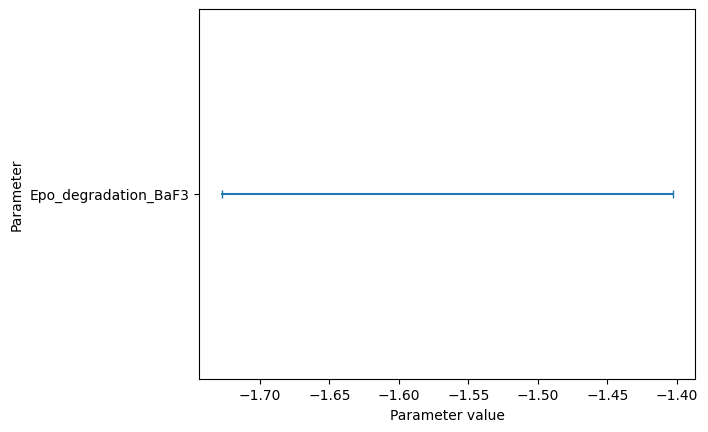

In [32]:
res, fig, ax = profile_cis(result, profile_list=2)

print("Nominal values of parameters:")
print(np.log10(petab_problem.parameter_df["nominalValue"]))

for (param, (lb, ub)) in res:
    print(param, ", CI is ", (lb, ub))

In [ ]:
# 5. Profile!
approximate_result = pypesto.profile.approximate_parameter_profile(
    problem=problem,
    result=result,
    optimizer=optimizer,
    engine=engine,
)

In [ ]:
# 4. Would like to use this startpoint for profiling
x_nominal = np.array(np.log10(petab_problem.parameter_df["nominalValue"]))

# Craft a result manually
artificial_result = pypesto.OptimizeResult()
artificial_result.append(pypesto.OptimizerResult(
    id = "0", 
    x = x_nominal, 
    fval = problem.objective(x_nominal[0:9]), 
    optimizer = optimizer
))
artificial_result.optimize_result = artificial_result

In [ ]:
# 5. Profile!
result = pypesto.profile.parameter_profile(
    problem=problem,
    result=artificial_result,
    optimizer=optimizer,
    engine=engine,
)

AttributeError: profile_result

In [ ]:
# 1. Import packages
import logging
import tempfile
from pprint import pprint
from collections.abc import Sequence
from typing import Union

import amici
import matplotlib as mpl
import numpy as np
import petab

import pypesto.optimize as optimize
import pypesto.petab
import pypesto.profile as profile
import pypesto.sample as sample
import pypesto.store as store
import pypesto.visualize as visualize
import pypesto.visualize.model_fit as model_fit

from pypesto.profile import calculate_approximate_ci, chi2_quantile_to_ratio
from pypesto.result import Result

import matplotlib.axes
import matplotlib.pyplot as plt
import numpy as np

# Set seed for reproducibility
np.random.seed(1912)

In [ ]:
# 2. Import the model
model_name = "Boehm_JProteomeRes2014"
petab_yaml = f"../../models/{model_name}/{model_name}.yaml"

petab_problem = petab.Problem.from_yaml(petab_yaml)
importer = pypesto.petab.PetabImporter(petab_problem)
problem = importer.create_problem(verbose=False)

In [ ]:
# 3. Setup optimizers
optimizer_options = {"maxiter": 1e4, "fatol": 1e-12, "frtol": 1e-12}
optimizer = optimize.FidesOptimizer(options=optimizer_options, verbose=logging.WARN)
optimizer_scipy_lbfgsb = optimize.ScipyOptimizer(method="L-BFGS-B")
optimizer_scipy_powell = optimize.ScipyOptimizer(method="Powell")

opt_options = optimize.OptimizeOptions()

n_starts = 1
engine = pypesto.engine.SingleCoreEngine()

In [ ]:
# 4. Minimize
result = optimize.minimize(
    problem=problem,
    optimizer=optimizer_scipy_lbfgsb,
    n_starts=n_starts,
    engine=engine,
    options=opt_options,
)

100%|██████████| 1/1 [00:06<00:00,  6.98s/it]


In [ ]:
res = result.optimize_result.as_list()[0]
res

{'id': '0',
 'x': array([-1.61861302,  5.        ,  0.06620852, -1.58796269,  5.        ,
         4.13591306,  0.693     ,  0.93089388,  0.69594267,  0.58477082,
         0.107     ]),
 'fval': 149.58782906607252,
 'grad': array([-1.05600446e-02, -3.06325314e-06,  4.53129778e-04, -1.81710202e-03,
        -1.09759960e-05,  1.73614569e-04,             nan, -1.63775239e-03,
         9.33937068e-04, -1.17724115e-06,             nan]),
 'hess': None,
 'res': None,
 'sres': None,
 'n_fval': 205,
 'n_grad': 205,
 'n_hess': 0,
 'n_res': 0,
 'n_sres': 0,
 'x0': array([-4.72537584, -3.8267521 ,  0.17032373,  0.5309411 ,  1.82691101,
        -0.13738387,  0.693     , -2.19222726,  2.40671846, -2.17865902,
         0.107     ]),
 'fval0': 1150653011.8154,
 'history': <pypesto.history.base.CountHistory at 0x7fe391b7a2d0>,
 'exitflag': 2,
 'time': 6.97322416305542,
 'message': 'ABNORMAL: ',
 'optimizer': "<ScipyOptimizer method=L-BFGS-B options={'disp': False, 'maxfun': 1000}>",
 'free_indices': ar

In [ ]:
res = result.optimize_result.as_list()[0]

x_nominal = np.array(np.log10(petab_problem.parameter_df["nominalValue"]))
new_res = pypesto.OptimizerResult(
    id="1",
    x=x_nominal,  
    fval=problem.objective(x_nominal[0:9]),
    optimizer=res['optimizer']
)


{'id': '1',
 'x': array([-1.56891759, -4.99970489, -2.20969878, -1.78600655,  4.99011401,
         4.19773549, -0.15926677,  0.58575527,  0.81898282,  0.4986844 ,
        -0.97061622]),
 'fval': 362.40196955539363,
 'grad': None,
 'hess': None,
 'res': None,
 'sres': None,
 'n_fval': None,
 'n_grad': None,
 'n_hess': None,
 'n_res': None,
 'n_sres': None,
 'x0': None,
 'fval0': None,
 'history': None,
 'exitflag': None,
 'time': None,
 'message': None,
 'optimizer': "<ScipyOptimizer method=L-BFGS-B options={'disp': False, 'maxfun': 1000}>",
 'free_indices': None,
 'inner_parameters': None,
 'spline_knots': None}

In [ ]:
result.optimize_result.append(new_res)

In [ ]:
print(result.optimize_result.summary())

TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

In [ ]:
result.optimize_result.as_list()[1]

{'id': '0',
 'x': array([-1.45035445,  3.69236283, -1.92159592, -1.80406735, -1.8974939 ,
         3.96596721,  0.693     ,  0.54194995,  0.8524631 ,  1.00050434,
         0.107     ]),
 'fval': 156.34086584161074,
 'grad': array([-3.22856080e-04, -2.18968089e-05, -1.69733912e-04,  2.02464251e-04,
        -3.28560722e-04,  1.78148280e-03,             nan,  6.24480539e-04,
         1.72388344e-04,  1.27974274e-04,             nan]),
 'hess': None,
 'res': None,
 'sres': None,
 'n_fval': 98,
 'n_grad': 98,
 'n_hess': 0,
 'n_res': 0,
 'n_sres': 0,
 'x0': array([-4.01268137,  2.55286839, -0.11791459, -1.53186333, -4.54171971,
         1.88975495,  0.693     , -1.94952623, -0.67531328, -1.19365571,
         0.107     ]),
 'fval0': 228597211.3740383,
 'history': <pypesto.history.base.CountHistory at 0x7fcbb43fd700>,
 'exitflag': 0,
 'time': 4.0556557178497314,
 'message': 'CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH',
 'optimizer': "<ScipyOptimizer method=L-BFGS-B options={'disp': F

In [ ]:
# 5. Profile
result = pypesto.profile.parameter_profile(
    problem=problem,
    result=result,
    optimizer=optimizer_scipy_lbfgsb,
    engine=engine,
    result_index=1,
    profile_index=[0]
)

100%|██████████| 1/1 [00:00<00:00, 413.56it/s]


In [ ]:
result.profile_result.list

[[{'x_path': array([[-1.56891759],
          [-4.99970489],
          [-2.20969878],
          [-1.78600655],
          [ 4.99011401],
          [ 4.19773549],
          [-0.15926677],
          [ 0.58575527],
          [ 0.81898282],
          [ 0.4986844 ],
          [-0.97061622]]),
   'fval_path': array([362.40196956]),
   'ratio_path': array([3.76697827e-93]),
   'gradnorm_path': array([nan]),
   'exitflag_path': array([None], dtype=object),
   'time_path': array([0.]),
   'color_path': array([[1, 0, 0, 1]]),
   'time_total': 0.0,
   'n_fval': 0,
   'n_grad': 0,
   'n_hess': 0,
   'message': None},
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None]]

In [ ]:
# 6. Print the CIs
def profile_cis(
    result: pypesto.Result,
    confidence_level: float = 0.95,
    profile_indices: Sequence[int] = None,
    profile_list: int = 0,
    color: Union[str, tuple] = "C0",
    show_bounds: bool = False,
    ax: matplotlib.axes.Axes = None,
) -> matplotlib.axes.Axes:
    """
    Plot approximate confidence intervals based on profiles.

    Parameters
    ----------
    result:
        The result object after profiling.
    confidence_level:
        The confidence level in (0,1), which is translated to an approximate
        threshold assuming a chi2 distribution, using
        `pypesto.profile.chi2_quantile_to_ratio`.
    profile_indices:
        List of integer values specifying which profiles should be plotted.
        Defaults to the indices for which profiles were generated in profile
        list `profile_list`.
    profile_list:
        Index of the profile list to be used.
    color:
        Main plot color.
    show_bounds:
        Whether to show, and extend the plot to, the lower and upper bounds.
    ax:
        Axes object to use. Default: Create a new one.
    """
    # extract problem
    problem = result.problem
    # extract profile list
    profile_list = result.profile_result.list[profile_list]

    if profile_indices is None:
        profile_indices = [ix for ix, res in enumerate(profile_list) if res]

    if ax is None:
        fig, ax = plt.subplots()

    confidence_ratio = chi2_quantile_to_ratio(confidence_level)

    # calculate intervals
    res = []
    intervals = []
    for i_par in range(problem.dim_full):
        if i_par not in profile_indices:
            continue
        xs = profile_list[i_par].x_path[i_par]
        ratios = profile_list[i_par].ratio_path
        lb, ub = calculate_approximate_ci(
            xs=xs, ratios=ratios, confidence_ratio=confidence_ratio
        )
        res.append((problem.x_names[i_par], (lb, ub)))
        intervals.append((lb, ub))

    x_names = [problem.x_names[ix] for ix in profile_indices]

    for ix, (lb, ub) in enumerate(intervals):
        ax.plot([lb, ub], [ix + 1, ix + 1], marker="|", color=color)

    parameters_ind = np.arange(1, len(intervals) + 1)
    ax.set_yticks(parameters_ind)
    ax.set_yticklabels(x_names)
    ax.set_ylabel("Parameter")
    ax.set_xlabel("Parameter value")

    if show_bounds:
        lb = problem.lb_full[profile_indices]
        ax.plot(lb, parameters_ind, "k--", marker="+")
        ub = problem.ub_full[profile_indices]
        ax.plot(ub, parameters_ind, "k--", marker="+")

    return res, fig, ax

Nominal values of parameters:
parameterId
Epo_degradation_BaF3   -1.568918
k_exp_hetero           -4.999705
k_exp_homo             -2.209699
k_imp_hetero           -1.786007
k_imp_homo              4.990114
k_phos                  4.197735
ratio                  -0.159267
sd_pSTAT5A_rel          0.585755
sd_pSTAT5B_rel          0.818983
sd_rSTAT5A_rel          0.498684
specC17                -0.970616
Name: nominalValue, dtype: float64
Epo_degradation_BaF3 , CI is  (np.float64(-1.735525095083418), np.float64(-1.313228398151176))


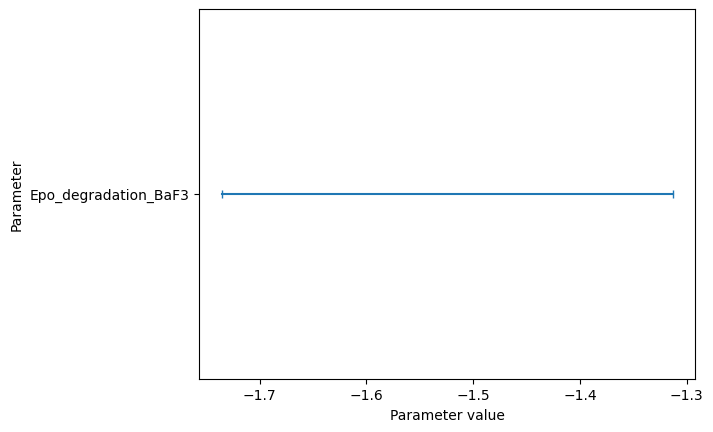

In [ ]:
res, fig, ax = profile_cis(result, profile_list=0)

print("Nominal values of parameters:")
print(np.log10(petab_problem.parameter_df["nominalValue"]))

for (param, (lb, ub)) in res:
    print(param, ", CI is ", (lb, ub))

In [ ]:
result.profile_result.list[0][4]['x_path'][0]

array([-1.38386757, -1.40881507, -1.43050954, ..., -1.56905677,
       -1.56905128, -1.56904594], shape=(5595,))